In [2]:
# Install the NumPy library for numerical operations and array manipulation
!pip install numpy

# Install PySpark, a distributed computing framework for big data processing
!pip install pyspark

# Install k-means-constrained, a library for performing k-means clustering with constraints
!pip install k-means-constrained

# Install NLTK (Natural Language Toolkit), a library for working with human language data
!pip install nltk

# Install pandas, a powerful data manipulation and analysis library
!pip install pandas

In [4]:
#importing classes from Libraries
from pyspark.sql import SparkSession #loading spark classes
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import pickle
from nltk.stem import PorterStemmer
import os
from sklearn.feature_extraction.text import TfidfVectorizer #loading tfidf vector
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
#defining column datatype for spark dataset
schema = StructType([
    StructField("photo_id", StringType()),
    StructField("title", StringType()),
    StructField("description", StringType()),
    StructField("tags", StringType()),
    StructField("faves", DoubleType())
])

In [8]:
# Creating a SparkSession named "HDFS" for working with Spark
spark = SparkSession.builder.appName("HDFS").getOrCreate()
sparkcont = SparkContext.getOrCreate(SparkConf().setAppName("HDFS"))
logs = sparkcont.setLogLevel("ERROR")

# Getting the absolute path of the CSV file in HDFS
filePath = os.path.abspath("/content/tourism.csv")

# Reading the CSV file into a Spark DataFrame with specified options
dataset = spark.read.csv("file:///" + filePath, header=True, inferSchema=True, schema=schema)

# Converting the Spark DataFrame to a Pandas DataFrame for local data manipulation
dataset = dataset.toPandas()

# Dropping rows with missing values (NaN)
dataset = dataset.dropna()

# Dropping duplicate rows in the dataset
dataset = dataset.drop_duplicates()

# Displaying the resulting Pandas DataFrame
dataset


,photo_id,title,description,tags,faves
0,47922891637,British Museum,"A marble statue of Emperor Septimius Severus, ...","britishmuseum, london, sculpture, roman",4.0
1,47922890172,British Museum,Busts of Roman worthies.,"britishmuseum, london, sculpture, roman",5.0
2,47922879348,British Museum,"A bronze bust of the emperor Lucius Verus, who...","britishmuseum, london, sculpture, roman, bronz...",7.0
3,46995613225,Ludgate House`Demolished,Heres A Special Request For Contact `RTM Boy` ...,"london, se1, southwark, blackfriars, local, hi...",4.0
6,40943646353,Sip Savor Enjoy,Nothing like a soothing cup of tea to enjoy in...,"stilllife, outdoors, park, trees, grass, drink...",3.0
...,...,...,...,...,...
9263,34652005736,20140913 200526 1SL4-COLLAGE,1S United Kingdom England London Cranbourn Street,"1s, 2046x2046x24b, 8c, canoncanoneos550d, cran...",0.0
9264,34562027021,20140913 161704 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1160s, 1s, 2046x2046x24b, 3456x2304x24b, 8c, c...",0.0
9265,34307675310,20140913 161556 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1s, 2046x2046x24b, 8c, canoncanoneos550d, engl...",0.0
9266,34692433725,20140912 190622 1SL4-SMILE,1S United Kingdom England London Bryanston Street,"1s, 2048x1366x24b, 8c, bryanstonstreet, canonc...",0.0


In [9]:
# Downloading NLTK's stopwords dataset
nltk.download('stopwords')

# Downloading NLTK's WordNet dataset
nltk.download('wordnet')

# Creating a set of English stopwords using NLTK
stop_words = set(stopwords.words('english'))

# Initializing a WordNet lemmatizer for lemmatization in NLP
lemmatizer = WordNetLemmatizer()

# Initializing a PorterStemmer for stemming in NLP
ps = PorterStemmer()

# Converting the set of stopwords to a list for easier manipulation
stop_words_list = list(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
#Defining cleanText method
def cleanText(doc):
    tokens = doc.split() # Splitting the input document into tokens (words)
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens] # Creating a translation table to remove punctuation from each token
    tokens = [word for word in tokens if word.isalpha()] # Removing non-alphabetic words
    tokens = [w for w in tokens if not w in stop_words] # Removing stopwords
    tokens = [word for word in tokens if len(word) > 1] # Removing short words (length less than 2 characters)
    tokens = [ps.stem(token) for token in tokens] # Stemming each token using PorterStemmer
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatizing each token using WordNetLemmatizer
    tokens = ' '.join(tokens)
    # Returning the cleaned text
    return tokens


In [11]:
#Creating tfidf method
temp = dataset.values
tfidf_X = []
for i in range(len(temp)):
    # Loop through all geotagged text from the dataset
    title = temp[i, 1]
    desc = temp[i, 2]
    tags = temp[i, 3]

    # Concatenate all values
    data = title.strip() + " " + desc.strip() + " " + tags.strip()

    # Convert to lowercase
    data = data.lower().strip()

    # Clean data using the 'cleanText' function (assumed to be defined elsewhere)
    data = cleanText(data)

    # Add clean data to the list
    tfidf_X.append(data)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words= None, use_idf=True, smooth_idf=False, norm=None, decode_error='replace', max_features=200)

# Fit and transform the text data to obtain the TF-IDF matrix
tfidf_X = tfidf_vectorizer.fit_transform(tfidf_X).toarray()

In [12]:
# Creating a KMeansConstrained object with 10 clusters and size constraints
kmeans = KMeansConstrained(n_clusters=10, size_min=200, size_max=tfidf_X.shape[0], random_state=0)

# Fitting the KMeansConstrained model to the TF-IDF matrix (tfidf_X)
kmeans.fit(tfidf_X)

# Predicting the cluster labels for each data point in the TF-IDF matrix
clusters = kmeans.predict(tfidf_X)

# Adding a new column 'cluster' to the original dataset to store the cluster labels
dataset['cluster'] = clusters

# Displaying the dataset with the assigned cluster labels
dataset

,photo_id,title,description,tags,faves,cluster
0,47922891637,British Museum,"A marble statue of Emperor Septimius Severus, ...","britishmuseum, london, sculpture, roman",4.0,1
1,47922890172,British Museum,Busts of Roman worthies.,"britishmuseum, london, sculpture, roman",5.0,1
2,47922879348,British Museum,"A bronze bust of the emperor Lucius Verus, who...","britishmuseum, london, sculpture, roman, bronz...",7.0,1
3,46995613225,Ludgate House`Demolished,Heres A Special Request For Contact `RTM Boy` ...,"london, se1, southwark, blackfriars, local, hi...",4.0,5
6,40943646353,Sip Savor Enjoy,Nothing like a soothing cup of tea to enjoy in...,"stilllife, outdoors, park, trees, grass, drink...",3.0,2
...,...,...,...,...,...,...
9263,34652005736,20140913 200526 1SL4-COLLAGE,1S United Kingdom England London Cranbourn Street,"1s, 2046x2046x24b, 8c, canoncanoneos550d, cran...",0.0,0
9264,34562027021,20140913 161704 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1160s, 1s, 2046x2046x24b, 3456x2304x24b, 8c, c...",0.0,0
9265,34307675310,20140913 161556 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1s, 2046x2046x24b, 8c, canoncanoneos550d, engl...",0.0,0
9266,34692433725,20140912 190622 1SL4-SMILE,1S United Kingdom England London Bryanston Street,"1s, 2048x1366x24b, 8c, bryanstonstreet, canonc...",0.0,0


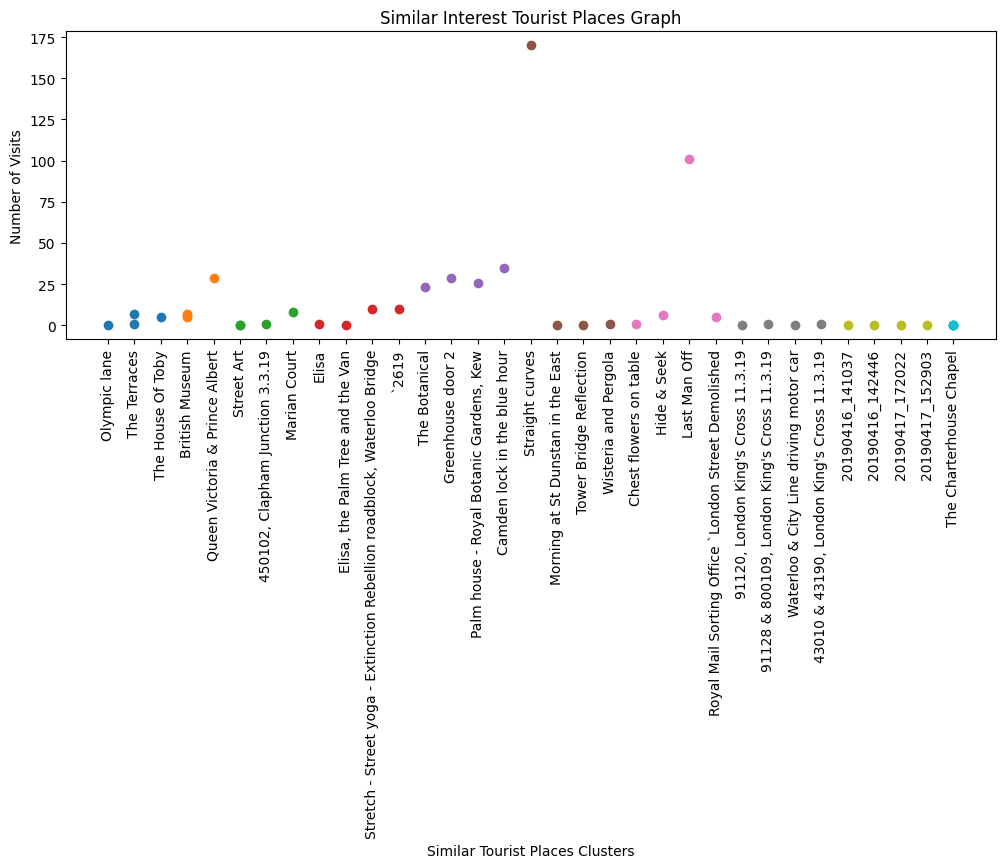

In [13]:
# Plotting a cluster graph with similar tourist interests and number of visits

# Setting the figure size for the plot
plt.figure(figsize=(12, 4))

# Iterating over each cluster (assumed to be 10 clusters)
for i in range(0, 10):
    # Selecting data points belonging to the current cluster
    cls1 = dataset[clusters == i]

    # Plotting a scatter plot for the selected data points
    plt.scatter(cls1.values[1:5, 1], cls1.values[1:5, 4])

# Rotating x-axis labels for better visibility
plt.xticks(rotation=90)

# Setting the x-axis label
plt.xlabel("Similar Tourist Places Clusters")

# Setting the y-axis label
plt.ylabel("Number of Visits")

# Setting the title of the plot
plt.title("Similar Interest Tourist Places Graph")

# Displaying the plot
plt.show()

In [14]:
# Taking user input for their interest
query = input("Enter your interest: ")

# Converting the user input to lowercase and cleaning the text using the cleanText function
data = query.lower()
data = cleanText(data)

# Creating a list containing the cleaned user input
temp = [data]

# Transforming the query using the TF-IDF vectorizer
temp_tfidf = tfidf_vectorizer.transform(temp).toarray()

# Using kmeans.predict on the transformed query to predict the cluster
predict = kmeans.predict(temp_tfidf, size_min=None, size_max=None)
predict = predict[0]

# Selecting data points from the dataset belonging to the predicted cluster
output = dataset[clusters == predict].nlargest(5, "faves")

# Calculating the total number of visitors for the selected data points
total_visited = np.sum(output['faves'])

# Displaying the total number of visitors
print("Total Number of Visitors: " + str(total_visited))
print()

# Displaying the top 5 tourist places based on user's interest and cluster
print(output)


Enter your interest: museum
Total Number of Visitors: 748.0

         photo_id                           title  \
3690  46528176411                  London classic   
8269  47362502411  London, Natural History Museum   
3821  46207905102                adequate scenery   
2502  40606920563             365in5theparcelyard   
2214  33821314158                Room with a View   

                                            description  \
3690  12mm ultra wide view into the hall of Natural ...   
8269                                           SONY DSC   
3821             Bride @ Natural History Museum, London   
2502  During a five year period, starting 01/01/17, ...   
2214             A View from The Tate Modern in London.   

                                                   tags  faves  cluster  
3690  london, england, uk, unitedkingdom, naturalhis...  264.0        1  
8269                               london, museum, nex3  232.0        1  
3821  greatbritain, england, grosbritannien